In [23]:
library(Seurat)
library(Matrix)
library(dplyr)
library(ggrepel)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(data.table)
library(vioplot)

In [3]:
# Fastq files from single-nucleus libraries were processed through Cell Ranger (v6.0.2) analysis pipeline with –include-introns 
# option and hg19 reference genome. Pooled library was demultiplexed and singlets were taken by demuxlet (v1.0). 
# Seurat (v4.0.5) package was used to handle single nuclei data objects. 
# Nuclei passed a control filter (number of genes > 500, number of reads >1000, percentage of mitochondrial gene < 10%) 
# was used for downstream analysis. Protein coding genes were used for further downstream analysis. 
# Data were normalized and scaled with the most variable 3000 features using the ‘SCTransform’ functions. 
# Dimensionality reduction by PCA and UMAP embedding was performed using runPCA and runUMAP functions. 
# Clustering was performed by FindNeighbors and FindClusters functions. 
# Cell type identification was performed using known cell type markers expressed in the brain including 
# excitatory (RORB, CUX2, SATB2), inhibitory neuron (GAD1, GAD2), astrocyte (SLC1A2, SLC1A3), 
# oligodendrocyte (MOBP, PLP1), immature oligodendrocyte (BCAS1), oligodendrocyte precursor cell (PDGFRA), 
# microglia (PTPRC), and endothelial cell markers (CLDN5, ID1) as well as using positive markers found 
# by FindAllMarkers function with 3000 most variable features in scaled data. 

# DEG analysis was performed by ‘FindMarkers’ function in Seurat v4.0 with all genes available in the assay. 
# The genes with adjusted p-value < 0.01 were taken and listed in Supplementary Table 5c. 
# The final visualization of various snRNAseq data was performed by ggplot2 (v3.3.5) and matplotlib (v3.5.0).

In [ ]:
# https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE218022
# https://pmc.ncbi.nlm.nih.gov/articles/PMC9961399/

In [4]:
library(future)
options(future.globals.maxSize = 20 * 1024^3) 

In [5]:
barcodes <- read.table(gzfile("GSE218022_barcodes.tsv.gz"), header = FALSE, stringsAsFactors = FALSE)
genes <- read.table(gzfile("GSE218022_genes.tsv.gz"), header = FALSE, stringsAsFactors = FALSE)
matrix <- readMM(gzfile("GSE218022_matrix.mtx.gz"))
metadata <- read.csv(gzfile("GSE218022_metadata.csv.gz"), header = TRUE, row.names = 1)

In [6]:
head(barcodes, 2)
head(genes, 2)
# head(matrix, 2)
head(metadata, 2)
colnames(metadata, 2)

V1                     
1 CTRL_AAACCCACAAATGGAT-1
2 CTRL_AAACCCAGTTGTAGCT-1

V1    
1 SAMD11
2 NOC2L

biosample_id donor_id species       
TYPE                    group        group    group         
CTRL_AAACCCACAAATGGAT-1 CTRL8352     CTRL8352 NCBITaxon:9606
                        species__ontology_label disease     
TYPE                    group                   group       
CTRL_AAACCCACAAATGGAT-1 homo sapiens            PATO_0000461
                        disease__ontology_label organ         
TYPE                    group                   group         
CTRL_AAACCCACAAATGGAT-1 normal                  UBERON:0000955
                        organ__ontology_label library_preparation_protocol
TYPE                    group                 group                       
CTRL_AAACCCACAAATGGAT-1 brain                 EFO:0009922                 
                        library_preparation_protocol__ontology_label sex    
TYPE                    group                                        group  
CTRL_AAACCCACAAATGGAT-1 10x 3' v3                                    unknown
                        nCount_RNA nFeature_RNA percent_mt  nCount_SCT
TYPE                    numeric    numeric      numeric     numeric   
CTRL_AAACCCACAAATGGAT-1 5099       2532         9.182186235 3865      
                        nFeature_SCT seurat_clusters cell_type 
TYPE                    numeric      group           group     
CTRL_AAACCCACAAATGGAT-1 2509         2               CL_0000498
                        cell_type__ontology_label cell_type_detail
TYPE                    group                     group           
CTRL_AAACCCACAAATGGAT-1 inhibitory interneuron    InN1

[1] "biosample_id"                                
 [2] "donor_id"                                    
 [3] "species"                                     
 [4] "species__ontology_label"                     
 [5] "disease"                                     
 [6] "disease__ontology_label"                     
 [7] "organ"                                       
 [8] "organ__ontology_label"                       
 [9] "library_preparation_protocol"                
[10] "library_preparation_protocol__ontology_label"
[11] "sex"                                         
[12] "nCount_RNA"                                  
[13] "nFeature_RNA"                                
[14] "percent_mt"                                  
[15] "nCount_SCT"                                  
[16] "nFeature_SCT"                                
[17] "seurat_clusters"                             
[18] "cell_type"                                   
[19] "cell_type__ontology_label"                   
[20] "cell_type_detail"

In [7]:
head(metadata, 2)

biosample_id donor_id species       
TYPE                    group        group    group         
CTRL_AAACCCACAAATGGAT-1 CTRL8352     CTRL8352 NCBITaxon:9606
                        species__ontology_label disease     
TYPE                    group                   group       
CTRL_AAACCCACAAATGGAT-1 homo sapiens            PATO_0000461
                        disease__ontology_label organ         
TYPE                    group                   group         
CTRL_AAACCCACAAATGGAT-1 normal                  UBERON:0000955
                        organ__ontology_label library_preparation_protocol
TYPE                    group                 group                       
CTRL_AAACCCACAAATGGAT-1 brain                 EFO:0009922                 
                        library_preparation_protocol__ontology_label sex    
TYPE                    group                                        group  
CTRL_AAACCCACAAATGGAT-1 10x 3' v3                                    unknown
                        nCount_RNA nFeature_RNA percent_mt  nCount_SCT
TYPE                    numeric    numeric      numeric     numeric   
CTRL_AAACCCACAAATGGAT-1 5099       2532         9.182186235 3865      
                        nFeature_SCT seurat_clusters cell_type 
TYPE                    numeric      group           group     
CTRL_AAACCCACAAATGGAT-1 2509         2               CL_0000498
                        cell_type__ontology_label cell_type_detail
TYPE                    group                     group           
CTRL_AAACCCACAAATGGAT-1 inhibitory interneuron    InN1

In [8]:
# Convert matrix to dgCMatrix (Seurat-compatible sparse format)
matrix <- as(matrix, "CsparseMatrix")

# Assign row and column names to match metadata
rownames(matrix) <- genes$V1  
colnames(matrix) <- barcodes$V1

# Check if metadata row names match colnames of matrix
if (!all(colnames(matrix) %in% rownames(metadata))) {
  stop("Error: Metadata row names do not match cell barcodes in the matrix.")
}

# Create Seurat object
seurat_obj <- CreateSeuratObject(counts = matrix, meta.data = metadata)

# Compute mitochondrial percentage if MT genes exist
if (any(grepl("^MT-", rownames(seurat_obj)))) {
  seurat_obj[["percent.mt"]] <- PercentageFeatureSet(seurat_obj, pattern = "^MT-")
} else {
  warning("No mitochondrial genes detected with the ^MT- pattern.")
}

# Set the default assay
DefaultAssay(seurat_obj) <- "RNA"

# Print summary
# print(seurat_obj)

Warning message:
“No mitochondrial genes detected with the ^MT- pattern.”


In [9]:
num_cells <- nrow(GetAssayData(seurat_obj, assay = "RNA", slot = "counts"))  # Number of cells
num_genes <- ncol(GetAssayData(seurat_obj, assay = "RNA", slot = "counts"))  # Number of genes

cat("Number of cells:", num_cells, "\n")
cat("Number of genes:", num_genes, "\n")

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


Number of cells: 16762 
Number of genes: 33206 


In [10]:
# Convert all three columns to numeric
metadata$nFeature_RNA <- as.numeric(metadata$nFeature_RNA)
metadata$nCount_RNA <- as.numeric(metadata$nCount_RNA)
metadata$percent_mt <- as.numeric(metadata$percent_mt)

# Print summary statistics for each column
summary(metadata[, c("nFeature_RNA", "nCount_RNA", "percent_mt")])

Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


  nFeature_RNA    nCount_RNA       percent_mt     
 Min.   : 515   Min.   :   605   Min.   :0.03376  
 1st Qu.:1243   1st Qu.:  1783   1st Qu.:1.16505  
 Median :1825   Median :  3168   Median :3.27470  
 Mean   :2100   Mean   :  5094   Mean   :3.73820  
 3rd Qu.:2664   3rd Qu.:  5877   3rd Qu.:5.75253  
 Max.   :9677   Max.   :143299   Max.   :9.99793  
 NA's   :1      NA's   :1        NA's   :1        

In [11]:
# Check if metadata columns are present
required_features <- c("nFeature_RNA", "nCount_RNA", "percent_mt", "seurat_clusters", "cell_type")
missing_features <- setdiff(required_features, colnames(seurat_obj@meta.data))

if (length(missing_features) > 0) {
  stop(paste("Error: Missing required metadata columns:", paste(missing_features, collapse = ", ")))
}

In [12]:
df = metadata

In [13]:
# Ensure seurat_clusters is a factor
df$seurat_clusters <- as.factor(df$seurat_clusters)
# Define colors for each cluster
cluster_colors <- rainbow(length(levels(df$seurat_clusters)))

# Convert to numeric safely, handling non-numeric values
df$nFeature_RNA <- as.numeric(as.character(df$nFeature_RNA))
df$nCount_RNA <- as.numeric(as.character(df$nCount_RNA))
df$percent_mt <- as.numeric(as.character(df$percent_mt))

# Remove NA values to prevent plotting errors
df <- df[!is.na(df$nFeature_RNA) & !is.na(df$nCount_RNA) & !is.na(df$percent_mt), ]

# Check if there are empty clusters after filtering
valid_clusters <- levels(df$seurat_clusters)[table(df$seurat_clusters) > 0]
print(valid_clusters)


 [1] "0"  "1"  "10" "11" "12" "13" "14" "15" "16" "17" "18" "19" "2"  "20" "21"
[16] "22" "23" "3"  "4"  "5"  "6"  "7"  "8"  "9" 


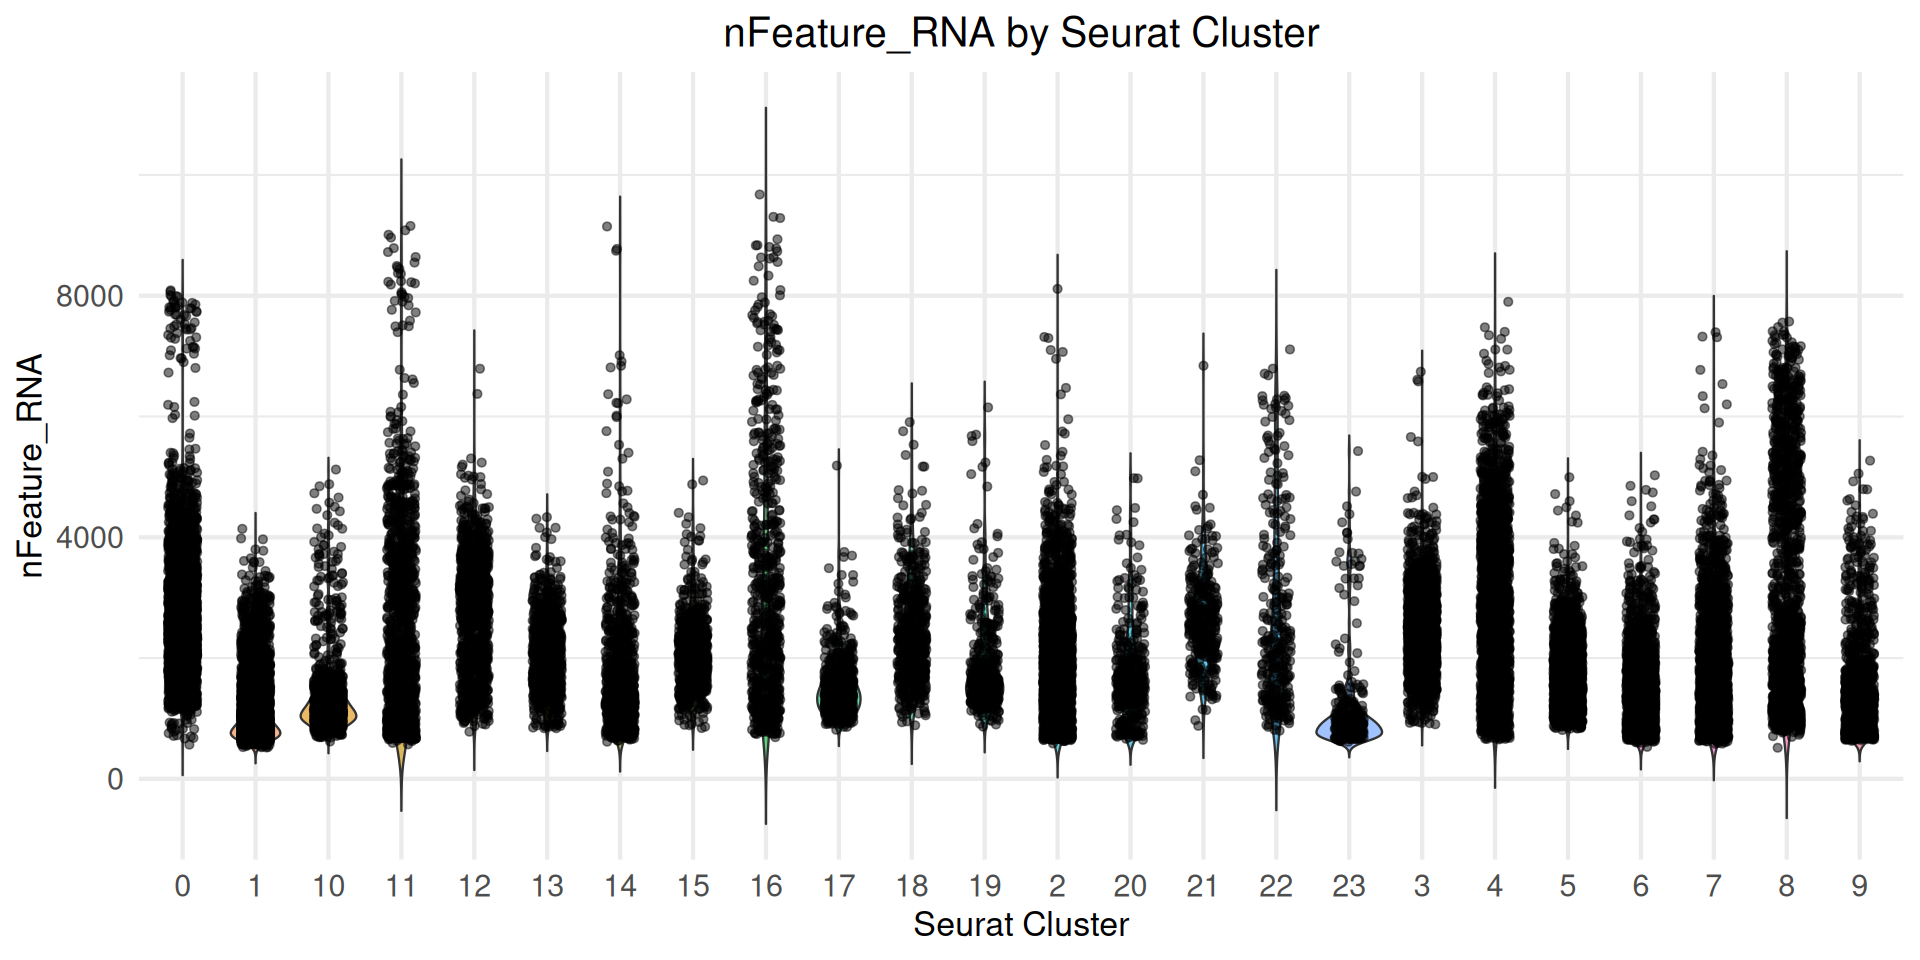

In [14]:
# Set a larger figure size for Jupyter Notebook
options(repr.plot.width = 16, repr.plot.height = 8)  # Increase width & height

# Ensure seurat_clusters is a factor
df$seurat_clusters <- as.factor(df$seurat_clusters)

# Convert to numeric safely
df$nFeature_RNA <- as.numeric(as.character(df$nFeature_RNA))

# Remove NA values
df <- df[!is.na(df$nFeature_RNA), ]

# Generate violin + jitter plot
ggplot(df, aes(x = seurat_clusters, y = nFeature_RNA, fill = seurat_clusters)) +
  geom_violin(trim = FALSE, alpha = 0.6) +  # Violin plot with transparency
  geom_jitter(width = 0.2, size = 1.8, color = "black", alpha = 0.5) +  # Jitter points
  theme_minimal(base_size = 20) +  # Larger base font size
  labs(title = "nFeature_RNA by Seurat Cluster", x = "Seurat Cluster", y = "nFeature_RNA") +
  theme(legend.position = "none",  # Remove legend
        plot.title = element_text(hjust = 0.5, size = 24),  # Center & enlarge title
        axis.text.x = element_text(size = 18),  # Increase x-axis text size
        axis.text.y = element_text(size = 18))  # Increase y-axis text size


Warning message:
“Removed 9 rows containing non-finite outside the scale range (`stat_ydensity()`).”
Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 234 rows containing missing values or values outside the scale range (`geom_violin()`).”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range (`geom_point()`).”


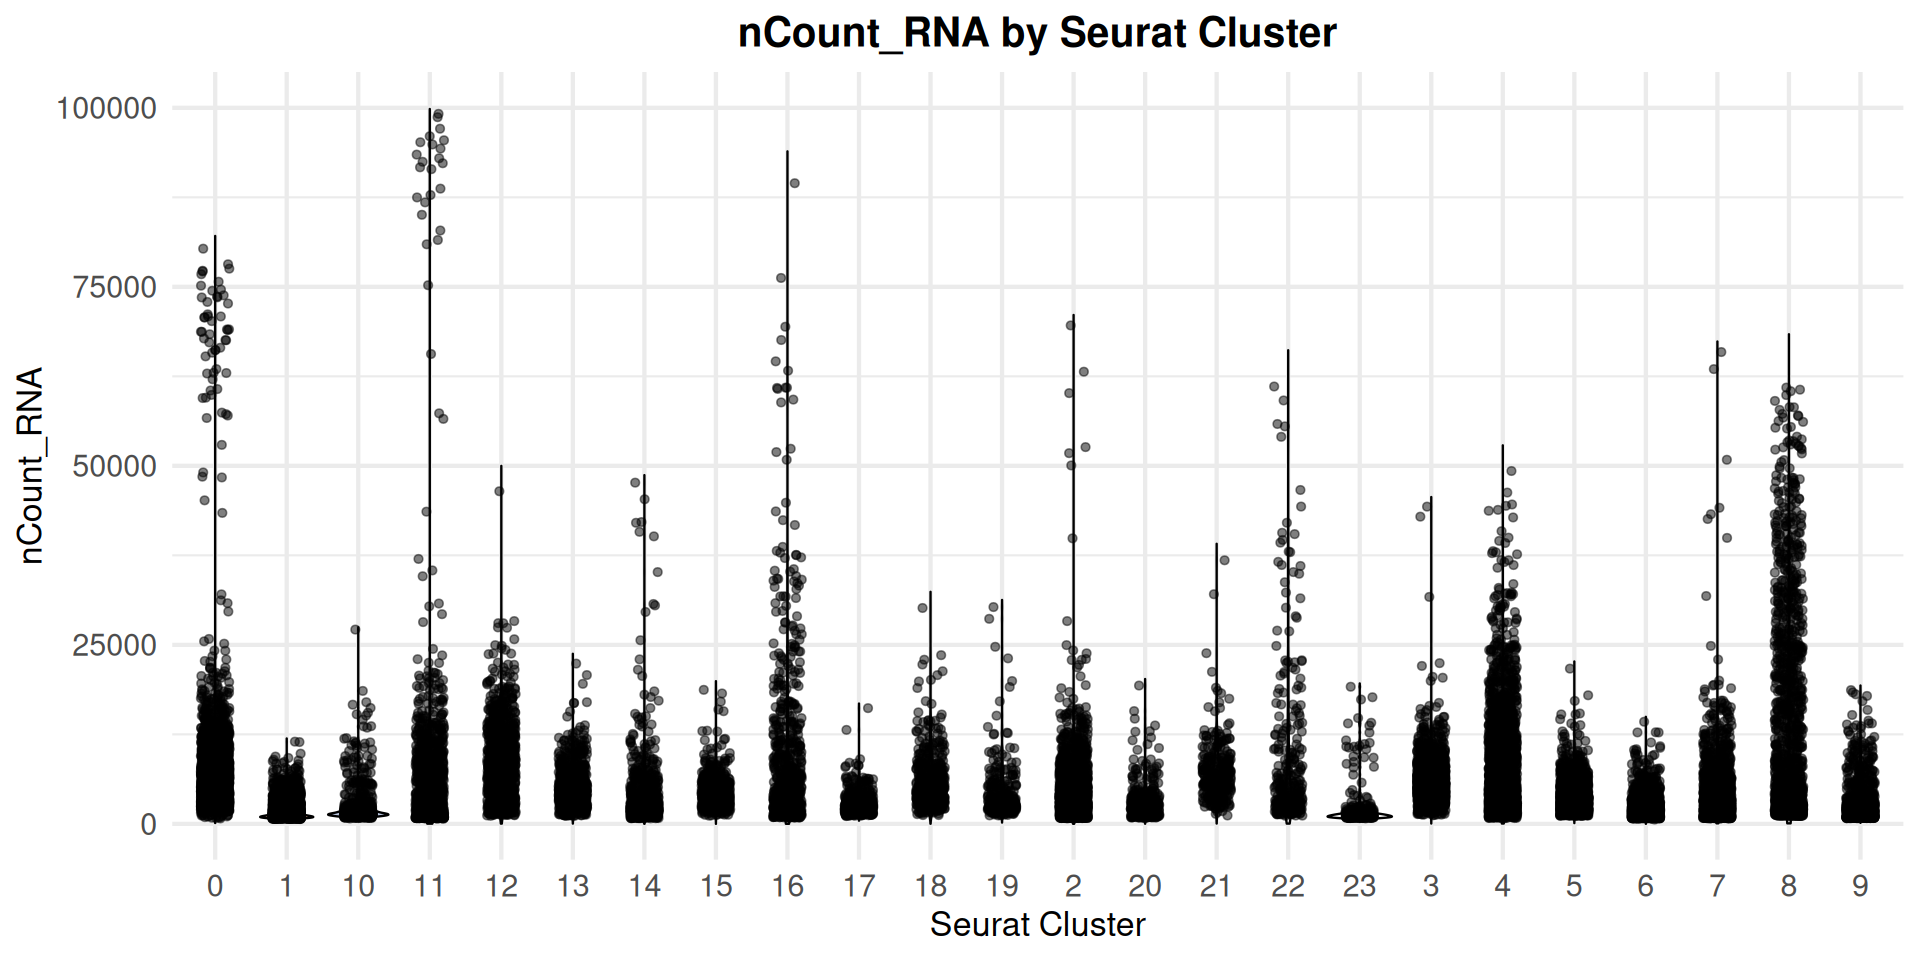

In [15]:
# Set a larger figure size for Jupyter Notebook
options(repr.plot.width = 16, repr.plot.height = 8)  # Increase width & height

# Ensure seurat_clusters is a factor
df$seurat_clusters <- as.factor(df$seurat_clusters)

# Convert to numeric safely
df$nCount_RNA <- as.numeric(as.character(df$nCount_RNA))

# Remove NA values
df <- df[!is.na(df$nCount_RNA), ]

# Generate violin + jitter plot for nCount_RNA with y-limit
ggplot(df, aes(x = seurat_clusters, y = nCount_RNA, fill = seurat_clusters)) +
  geom_violin(trim = FALSE, alpha = 0.6, color = "black") +  # Violin plot with transparency and black outline
  geom_jitter(width = 0.2, size = 1.8, color = "black", alpha = 0.5) +  # Jitter points
  scale_fill_brewer(palette = "Set2") +  # Nice color palette
  ylim(0, 100000) +  # Set y-axis limit
  theme_minimal(base_size = 20) +  # Larger base font size
  labs(title = "nCount_RNA by Seurat Cluster", 
       x = "Seurat Cluster", 
       y = "nCount_RNA") +
  theme(legend.position = "none",  # Remove legend
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),  # Center & bold title
        axis.text.x = element_text(size = 18),  # Increase x-axis text size
        axis.text.y = element_text(size = 18))  # Increase y-axis text size

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Set2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 1107 rows containing missing values or values outside the scale range (`geom_violin()`).”


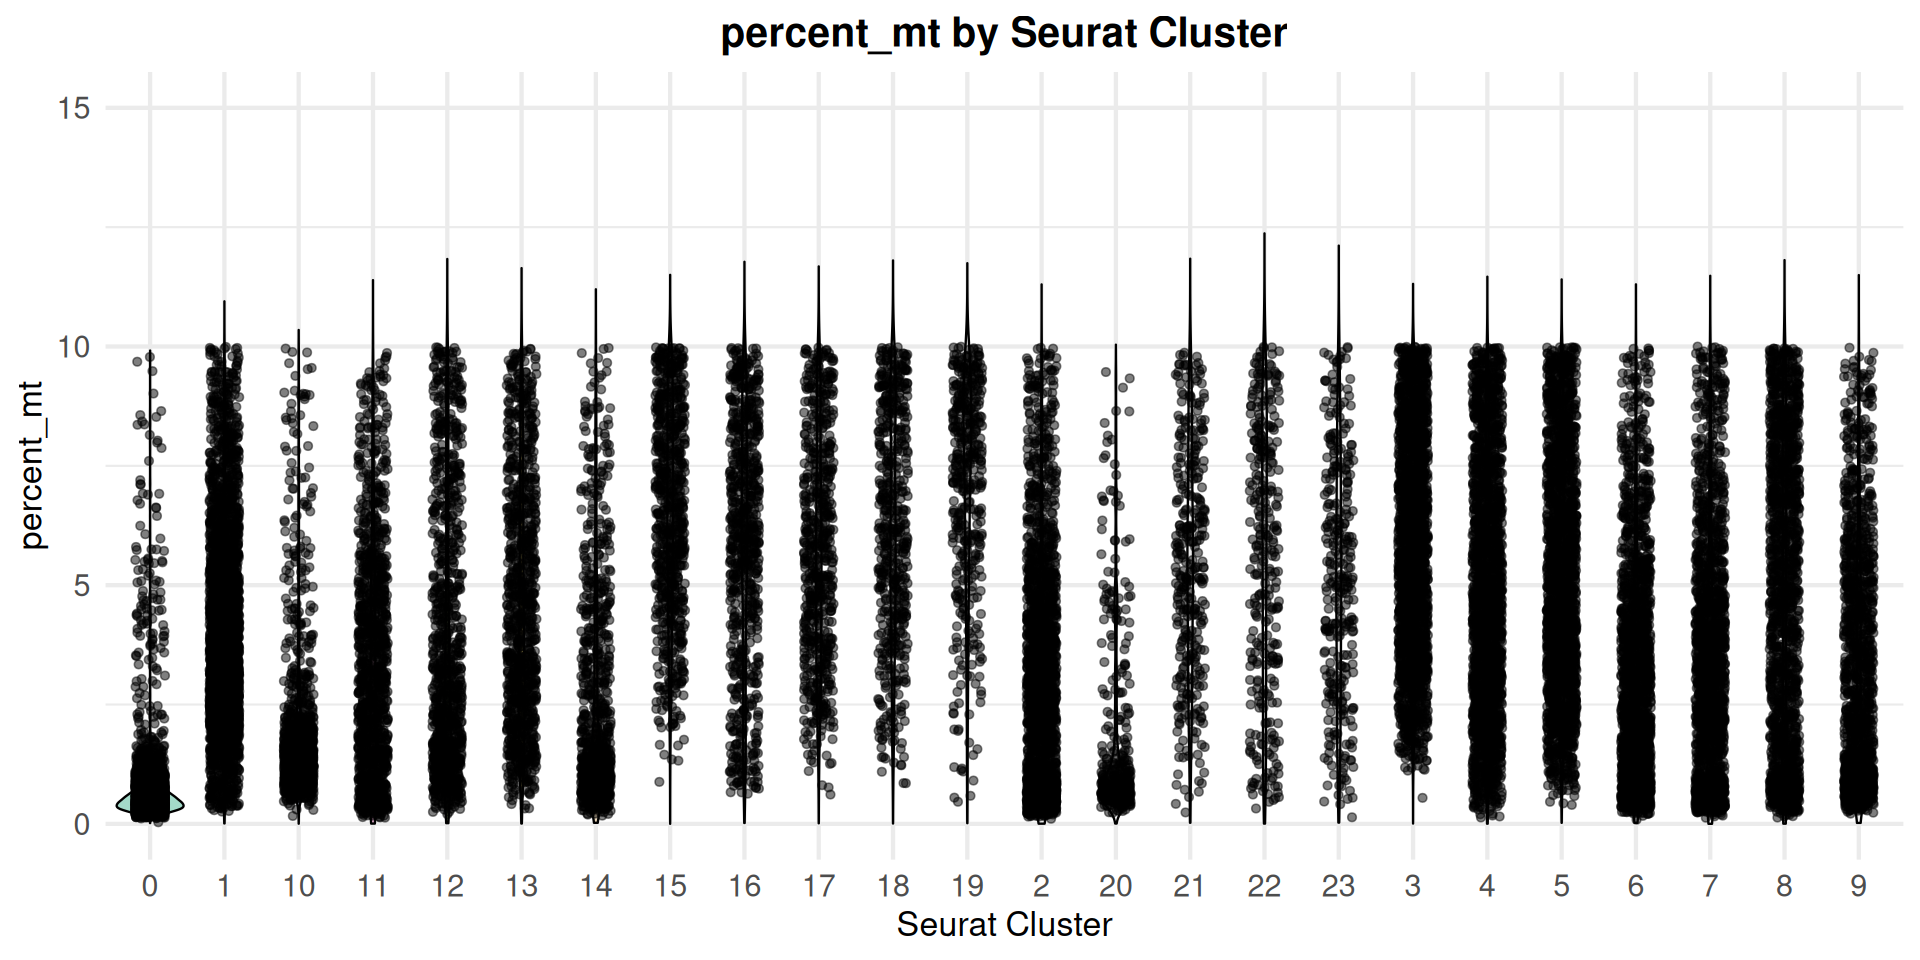

In [13]:
# Set a larger figure size for Jupyter Notebook
options(repr.plot.width = 16, repr.plot.height = 8)  # Increase width & height

# Ensure seurat_clusters is a factor
df$seurat_clusters <- as.factor(df$seurat_clusters)

# Convert to numeric safely
df$percent_mt <- as.numeric(as.character(df$percent_mt))

# Remove NA values
df <- df[!is.na(df$percent_mt), ]

# Generate violin + jitter plot for percent_mt with y-limit
ggplot(df, aes(x = seurat_clusters, y = percent_mt, fill = seurat_clusters)) +
  geom_violin(trim = FALSE, alpha = 0.6, color = "black") +  # Violin plot with transparency and black outline
  geom_jitter(width = 0.2, size = 1.8, color = "black", alpha = 0.5) +  # Jitter points
  scale_fill_brewer(palette = "Set2") +  # Nice color palette
  ylim(0, 15) +  # Set y-axis limit to 100%
  theme_minimal(base_size = 20) +  # Larger base font size
  labs(title = "percent_mt by Seurat Cluster", 
       x = "Seurat Cluster", 
       y = "percent_mt") +
  theme(legend.position = "none",  # Remove legend
        plot.title = element_text(hjust = 0.5, size = 24, face = "bold"),  # Center & bold title
        axis.text.x = element_text(size = 18),  # Increase x-axis text size
        axis.text.y = element_text(size = 18))  # Increase y-axis text size


Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette Dark2 is 8
Returning the palette you asked for with that many colors
”
Warning message:
“Removed 19638 rows containing missing values or values outside the scale range (`geom_point()`).”


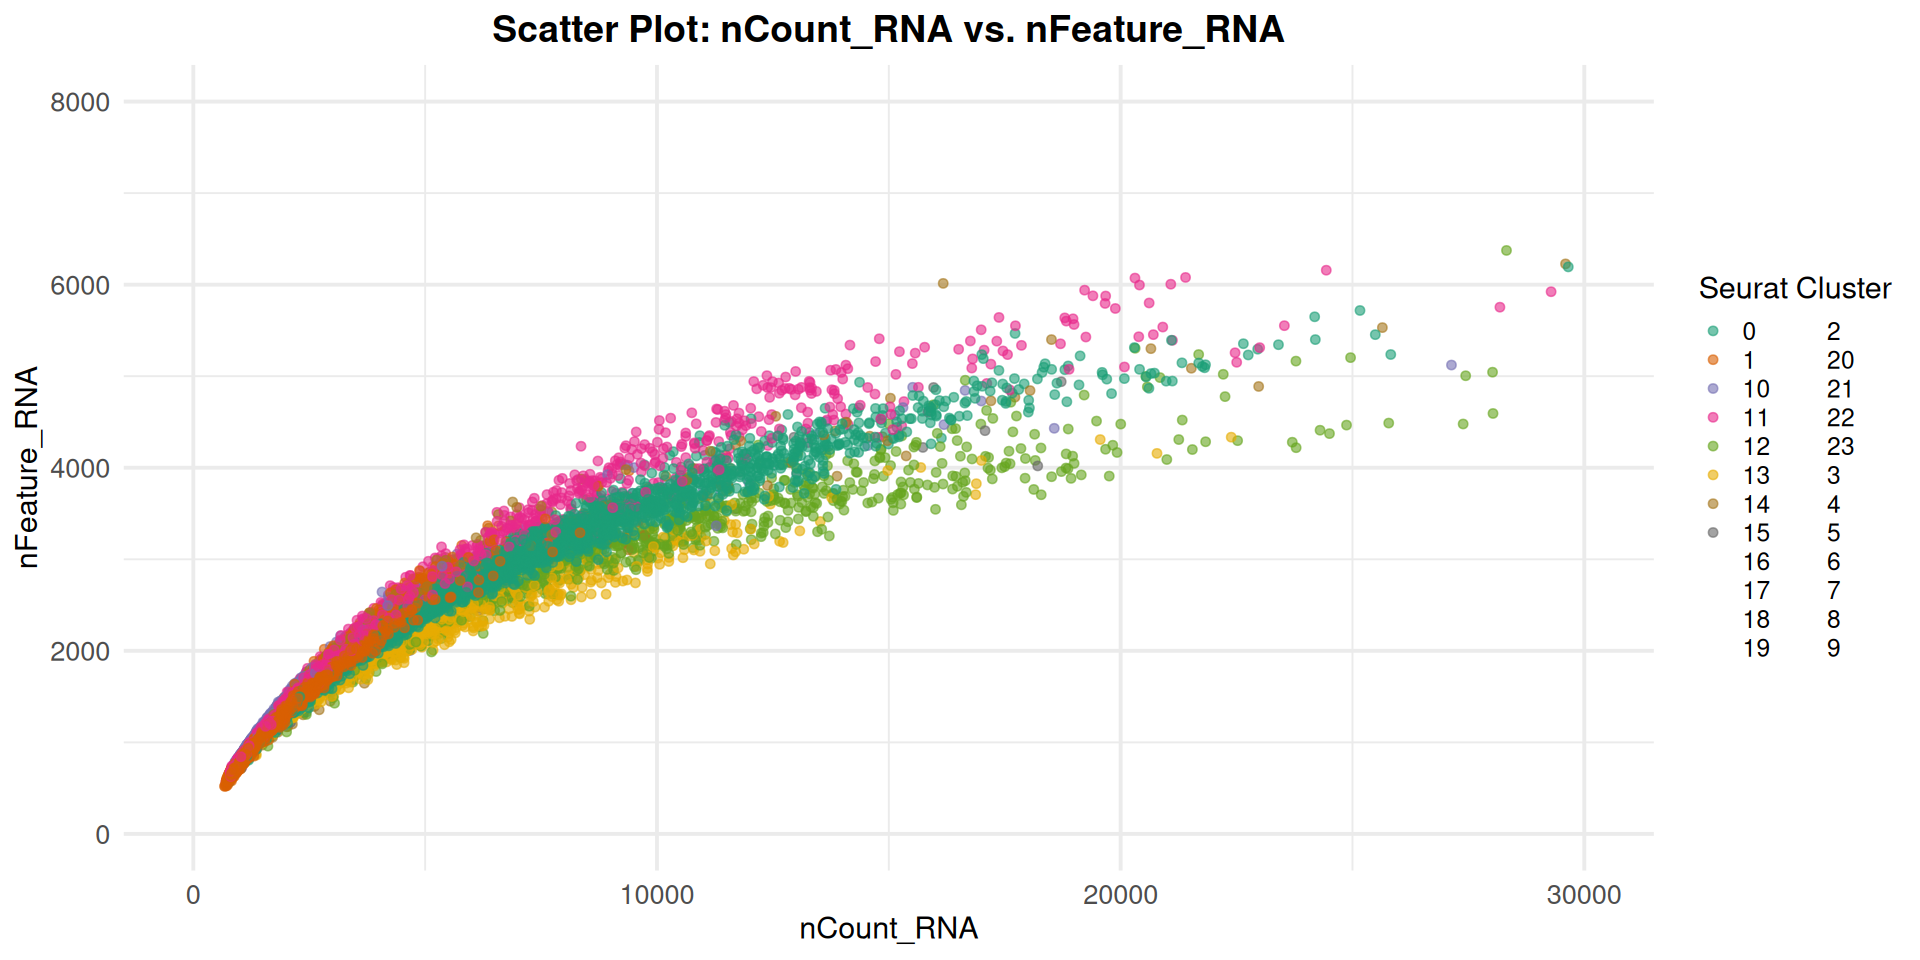

In [16]:
# Generate scatter plot
ggplot(df, aes(x = nCount_RNA, y = nFeature_RNA, color = seurat_clusters)) +
  geom_point(alpha = 0.6, size = 2) +  # Scatter plot points with transparency
  scale_color_brewer(palette = "Dark2") +  # Color scheme for clusters
  theme_minimal(base_size = 18) +  # Bigger font sizes
  labs(title = "Scatter Plot: nCount_RNA vs. nFeature_RNA", 
       x = "nCount_RNA", 
       y = "nFeature_RNA", 
       color = "Seurat Cluster") +  # Color legend
  xlim(0, 30000) +  # Custom x-axis limits
  ylim(0, 8000) +  # Custom y-axis limits
  theme(plot.title = element_text(hjust = 0.5, size = 22, face = "bold"),  # Center & bold title
        axis.text.x = element_text(size = 16),  # Larger x-axis labels
        axis.text.y = element_text(size = 16))  # Larger y-axis labels

In [15]:
# seurat_obj <- subset(seurat_obj, subset = nFeature_RNA > 200 & nFeature_RNA < 3000 &
#                                  nCount_RNA > 200 & nCount_RNA < 10000 &
#                                  percent_mt < 10)

# num_cells <- ncol(GetAssayData(seurat_obj, assay = "RNA", slot = "counts"))  # Number of cells
# num_genes <- nrow(GetAssayData(seurat_obj, assay = "RNA", slot = "counts"))  # Number of genes

# cat("Number of cells:", num_cells, "\n")
# cat("Number of genes:", num_genes, "\n")
# head(metadata)

In [20]:
# head(GetAssayData(seurat_obj, assay = "RNA", slot = "counts"), 3)

In [20]:
seurat_obj@meta.data$cell_type <- as.factor(seurat_obj@meta.data$cell_type_detail)
unique(seurat_obj@meta.data$cell_type)
length(unique(seurat_obj@meta.data$cell_type))

[1] InN1   ExN3   InN2   OPC    OD     Ast    EC     ImmOD  MG     Ast-L2
[11] U      ExN1   ExN2   OD-L   ExN-L2 Ast-L3 OPC-L2 ExN-L1 OPC-L1 Ast-L1
20 Levels: Ast Ast-L1 Ast-L2 Ast-L3 EC ExN-L1 ExN-L2 ExN1 ExN2 ExN3 ... U

[1] 20

In [18]:
check_seurat_data <- function(seurat_obj) {
  found_data <- FALSE  # Flag to track if any data is found
  
  for (assay in Assays(seurat_obj)) {
    slots <- slotNames(seurat_obj[[assay]])
    
    if ("data" %in% slots) {
      message("✅ Normalized data found in: ", assay)
      found_data <- TRUE
    }
    
    if ("scale.data" %in% slots) {
      message("✅ Standardized (scaled) data found in: ", assay)
      found_data <- TRUE
    }
  }
  
  if (!found_data) {
    message("❌ No normalized or standardized data found in any assay.")
  }
}

check_seurat_data(seurat_obj)

❌ No normalized or standardized data found in any assay.



In [24]:
# Normalize the data
seurat_obj <- NormalizeData(seurat_obj, normalization.method = "LogNormalize", scale.factor = 10000)

# Identify highly variable features
seurat_obj <- FindVariableFeatures(seurat_obj, selection.method = "vst", nfeatures = 2000)

# Scale the data
seurat_obj <- ScaleData(seurat_obj, features = rownames(seurat_obj))

# Alternatively, we can use SCTransform. 

# Normalize & standardize data using SCTransform (with top 3000 variable features)
# seurat_obj <- SCTransform(seurat_obj, variable.features.n = 3000, verbose = FALSE)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



[1] "variable features"
 [1] "ITM2A"  "ABCB1"  "FLT1"   "IFI27"  "ATP10A" "RGS5"   "EBF1"   "SLC7A5"
 [9] "CLDN5"  "B2M"   


Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


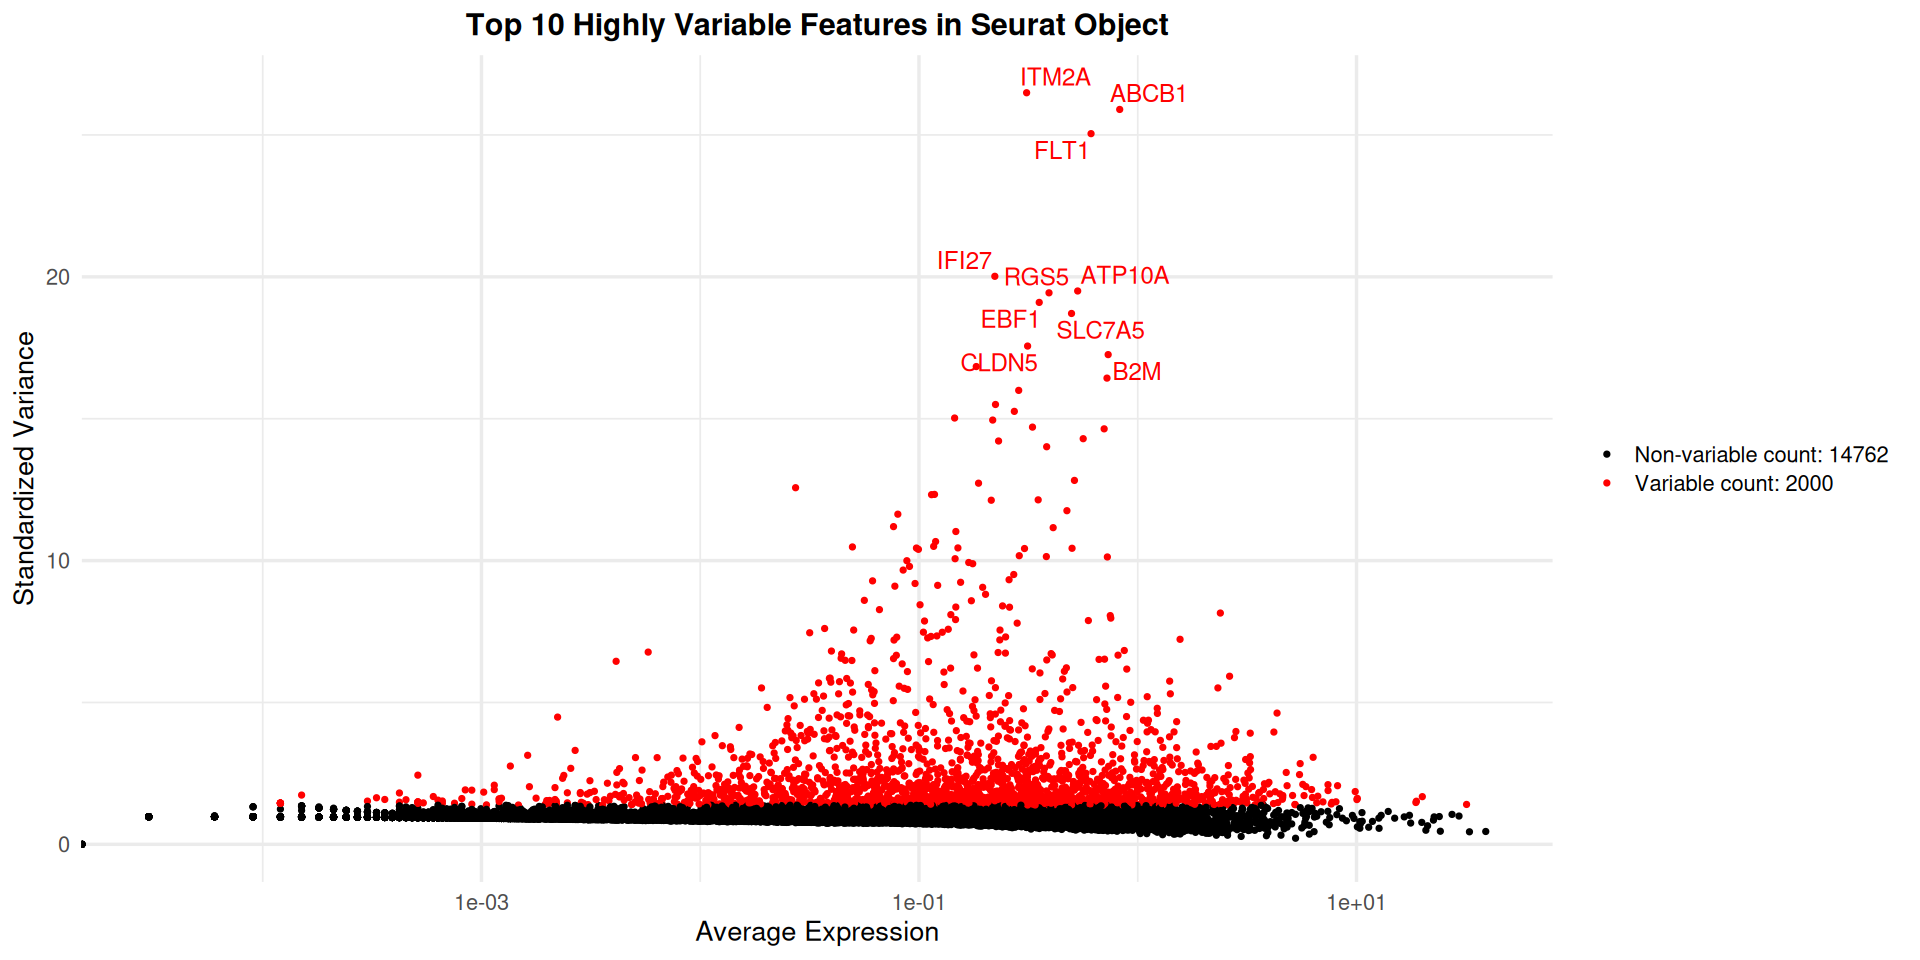

In [25]:
print("variable features") 

variable_features_df <- HVFInfo(seurat_obj)
variable_features_df$gene <- rownames(variable_features_df)  # Add gene names as a column

# Extract top 10 variable genes
top10_genes <- head(VariableFeatures(seurat_obj), 10)
print(top10_genes)
      
# Generate base variable feature plot
plot <- VariableFeaturePlot(seurat_obj)

# Add labels for the top 10 most variable features
plot + 
  geom_text_repel(data = subset(variable_features_df, gene %in% top10_genes), 
                  aes(x = mean, y = variance.standardized, label = gene), 
                  size = 5, color = "red", max.overlaps = Inf) +  # Use ggrepel to avoid overlap
  theme_minimal(base_size = 16) +
  labs(title = "Top 10 Highly Variable Features in Seurat Object") +
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"))

In [18]:
# save.image(file = "estephany1.RData")

In [35]:
head(metadata,3)
metadata[1,1]
unique(seurat_obj@meta.data$cell_type_detail)
length(unique(metadata$cell_type_detail))

[1] "group"  "InN1"   "ExN3"   "InN2"   "OPC"    "OD"     "Ast"    "EC"    
 [9] "ImmOD"  "MG"     "Ast-L2" "U"      "ExN1"   "ExN2"   "OD-L"   "ExN-L2"
[17] "Ast-L3" "OPC-L2" "ExN-L1" "OPC-L1" "Ast-L1"

[1] 21

biosample_id donor_id species       
TYPE                    group        group    group         
CTRL_AAACCCACAAATGGAT-1 CTRL8352     CTRL8352 NCBITaxon:9606
CTRL_AAACCCAGTTGTAGCT-1 CTRL8352     CTRL8352 NCBITaxon:9606
                        species__ontology_label disease     
TYPE                    group                   group       
CTRL_AAACCCACAAATGGAT-1 homo sapiens            PATO_0000461
CTRL_AAACCCAGTTGTAGCT-1 homo sapiens            PATO_0000461
                        disease__ontology_label organ         
TYPE                    group                   group         
CTRL_AAACCCACAAATGGAT-1 normal                  UBERON:0000955
CTRL_AAACCCAGTTGTAGCT-1 normal                  UBERON:0000955
                        organ__ontology_label library_preparation_protocol
TYPE                    group                 group                       
CTRL_AAACCCACAAATGGAT-1 brain                 EFO:0009922                 
CTRL_AAACCCAGTTGTAGCT-1 brain                 EFO:0009922                 
                        library_preparation_protocol__ontology_label sex    
TYPE                    group                                        group  
CTRL_AAACCCACAAATGGAT-1 10x 3' v3                                    unknown
CTRL_AAACCCAGTTGTAGCT-1 10x 3' v3                                    unknown
                        nCount_RNA nFeature_RNA percent_mt nCount_SCT
TYPE                      NA         NA               NA   numeric   
CTRL_AAACCCACAAATGGAT-1 5099       2532         9.182186   3865      
CTRL_AAACCCAGTTGTAGCT-1 7584       3257         7.130065   4023      
                        nFeature_SCT seurat_clusters cell_type 
TYPE                    numeric      group           group     
CTRL_AAACCCACAAATGGAT-1 2509         2               CL_0000498
CTRL_AAACCCAGTTGTAGCT-1 2654         2               CL_0000498
                        cell_type__ontology_label cell_type_detail
TYPE                    group                     group           
CTRL_AAACCCACAAATGGAT-1 inhibitory interneuron    InN1            
CTRL_AAACCCAGTTGTAGCT-1 inhibitory interneuron    InN1

[1] "group"

[1] "InN1"   "ExN3"   "InN2"   "OPC"    "OD"     "Ast"    "EC"     "ImmOD" 
 [9] "MG"     "Ast-L2" "U"      "ExN1"   "ExN2"   "OD-L"   "ExN-L2" "Ast-L3"
[17] "OPC-L2" "ExN-L1" "OPC-L1" "Ast-L1"

In [31]:
# Perform PCA
seurat_obj <- RunPCA(seurat_obj, features = VariableFeatures(seurat_obj))

PC_ 1 
Positive:  CNTNAP2, NRXN3, KCNIP4, ROBO2, RYR2, ERC2, CCSER1, STXBP5L, KCNQ5, GRIN2A 
	   RALYL, KHDRBS2, AGBL4, ASIC2, FRMPD4, CACNA1B, KIRREL3, LINGO2, GRM5, NKAIN2 
	   NRG1, GABRB3, ATP8A2, RBFOX3, NEGR1, RGS7, IQCJ-SCHIP1, CHRM3, GABRG3, CACNA2D3 
Negative:  EBF1, EPAS1, LEF1, ITM2A, FLT1, ABCG2, ABCB1, ID1, ENG, MYO10 
	   EMCN, CLDN5, ATP1A2, PREX2, CGNL1, IFI27, VWF, SOX18, MECOM, ERG 
	   SLC1A3, FBXL7, SLC7A11, KDR, RAMP2, FN1, IGFBP7, CDH5, FOXC1, PON2 
PC_ 2 
Positive:  SLC1A3, SLC1A2, FBXL7, ACSBG1, FGFR2, ATP13A4, SLC4A4, SLCO1C1, RFX4, GPC5 
	   GLI3, RANBP3L, ACSS1, PRDM16, SLC25A18, PARD3B, NKAIN3, MSI2, EYA2, STON2 
	   BMPR1B, RGS20, NHSL1, PRODH, LRIG1, ARHGEF26, PREX2, LRP4, C4orf19, ALDH1A1 
Negative:  ABCB1, EBF1, SLC7A5, ERG, EMCN, LEF1, FLT1, PODXL, ST8SIA6, ITM2A 
	   MECOM, CLDN5, PTPRB, MYRIP, ATP10A, COBLL1, SOX18, ABCG2, KDR, CYYR1 
	   SLC39A10, VWF, CDH5, HMCN1, EGFL7, FOXQ1, ESAM, IFI27, ID1, PDE10A 
PC_ 3 
Positive:  SHROOM3, FAT3, SLC4A4, ZNRF3

Warning message:
“Removed 644 rows containing missing values or values outside the scale range (`geom_point()`).”


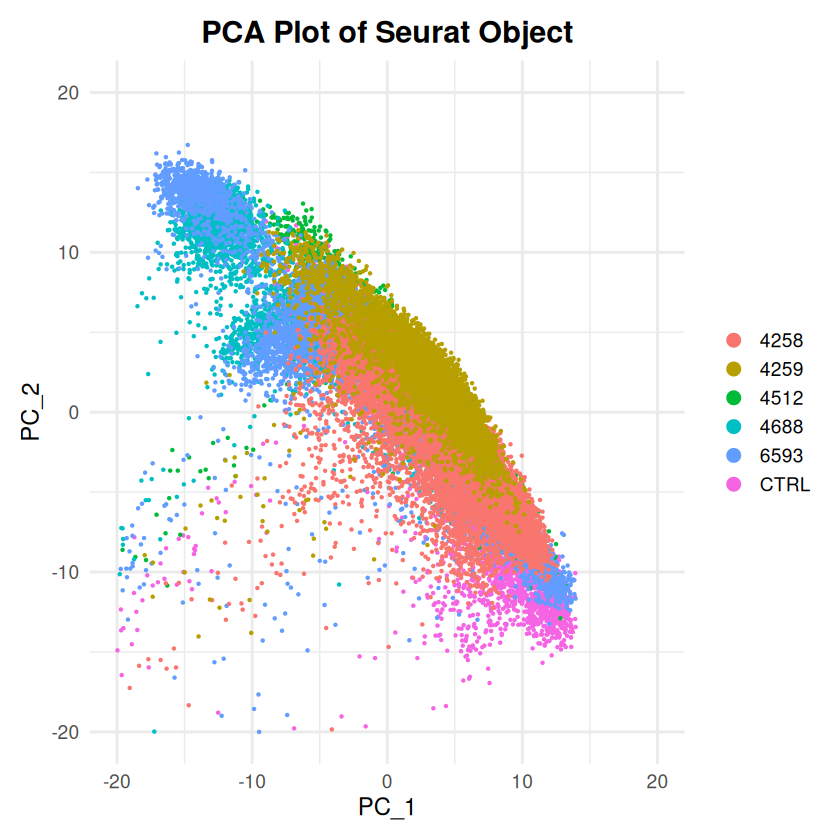

In [21]:
# Plot PCA using DimPlot
DimPlot(seurat_obj, reduction = "pca") +
  theme_minimal(base_size = 14) +
  labs(title = "PCA Plot of Seurat Object") +
  xlim(-20, 20) +  
  ylim(-20, 20) +  
  theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"))

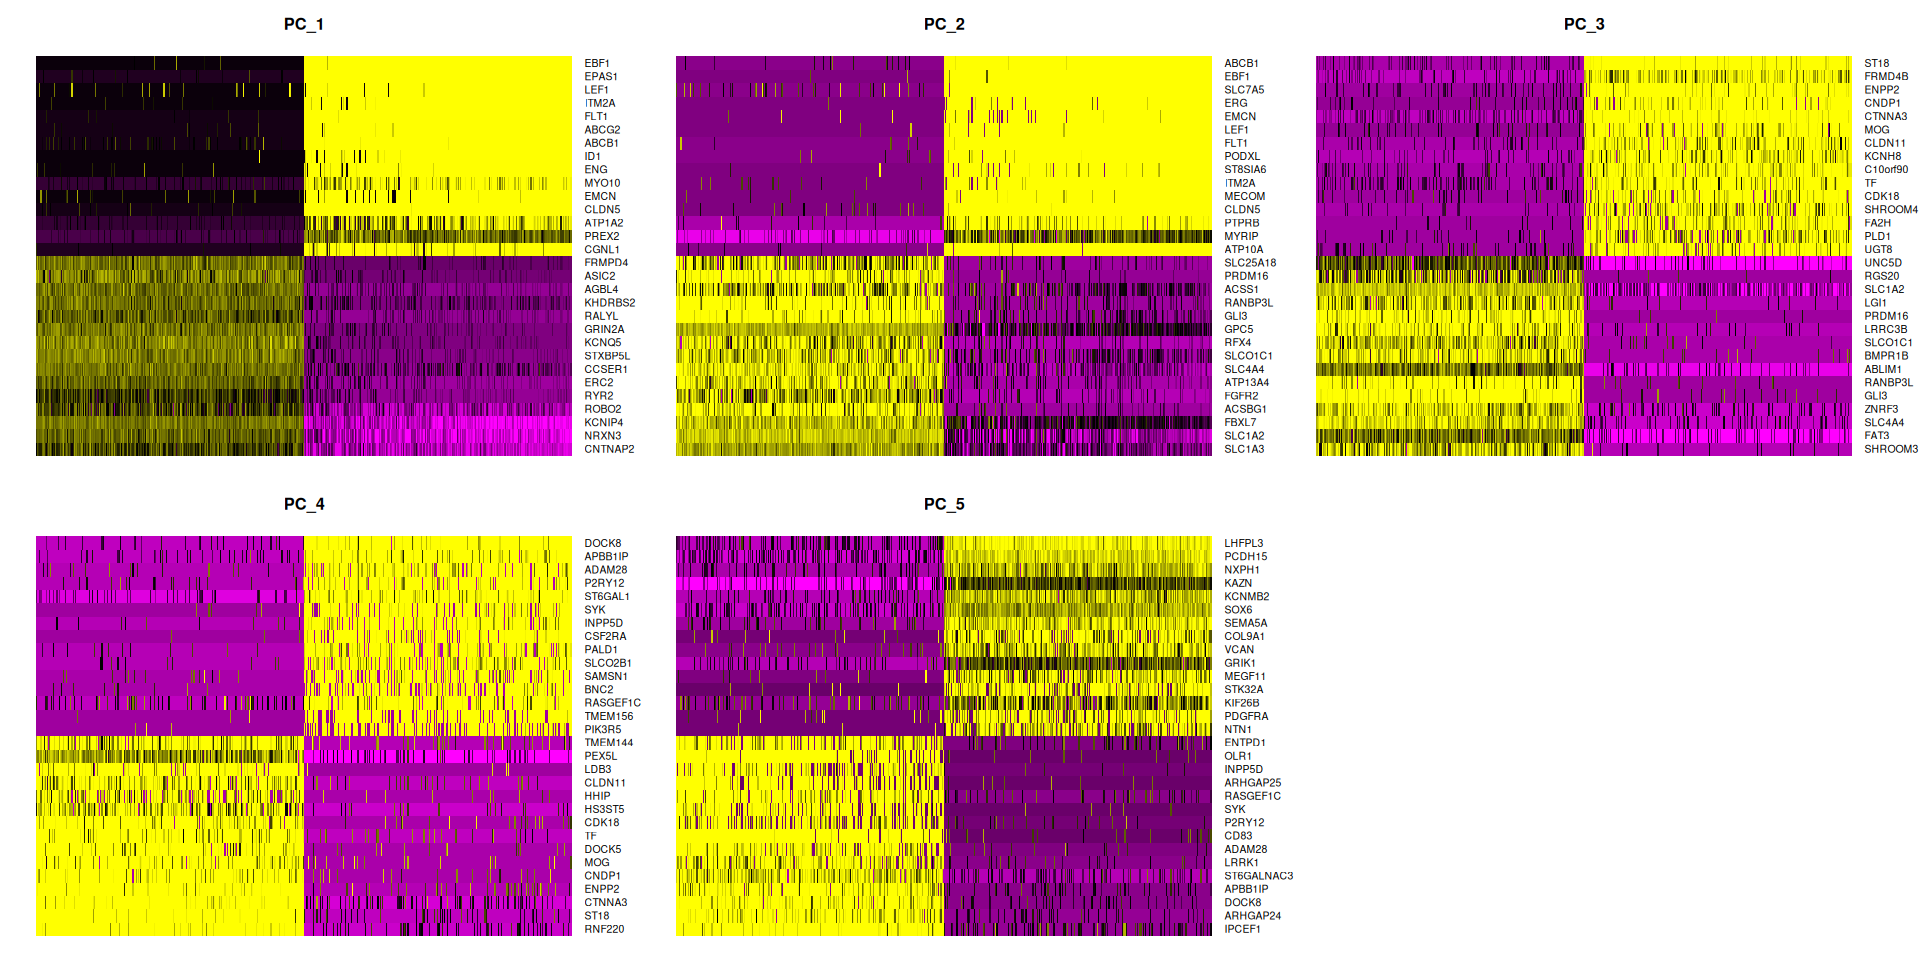

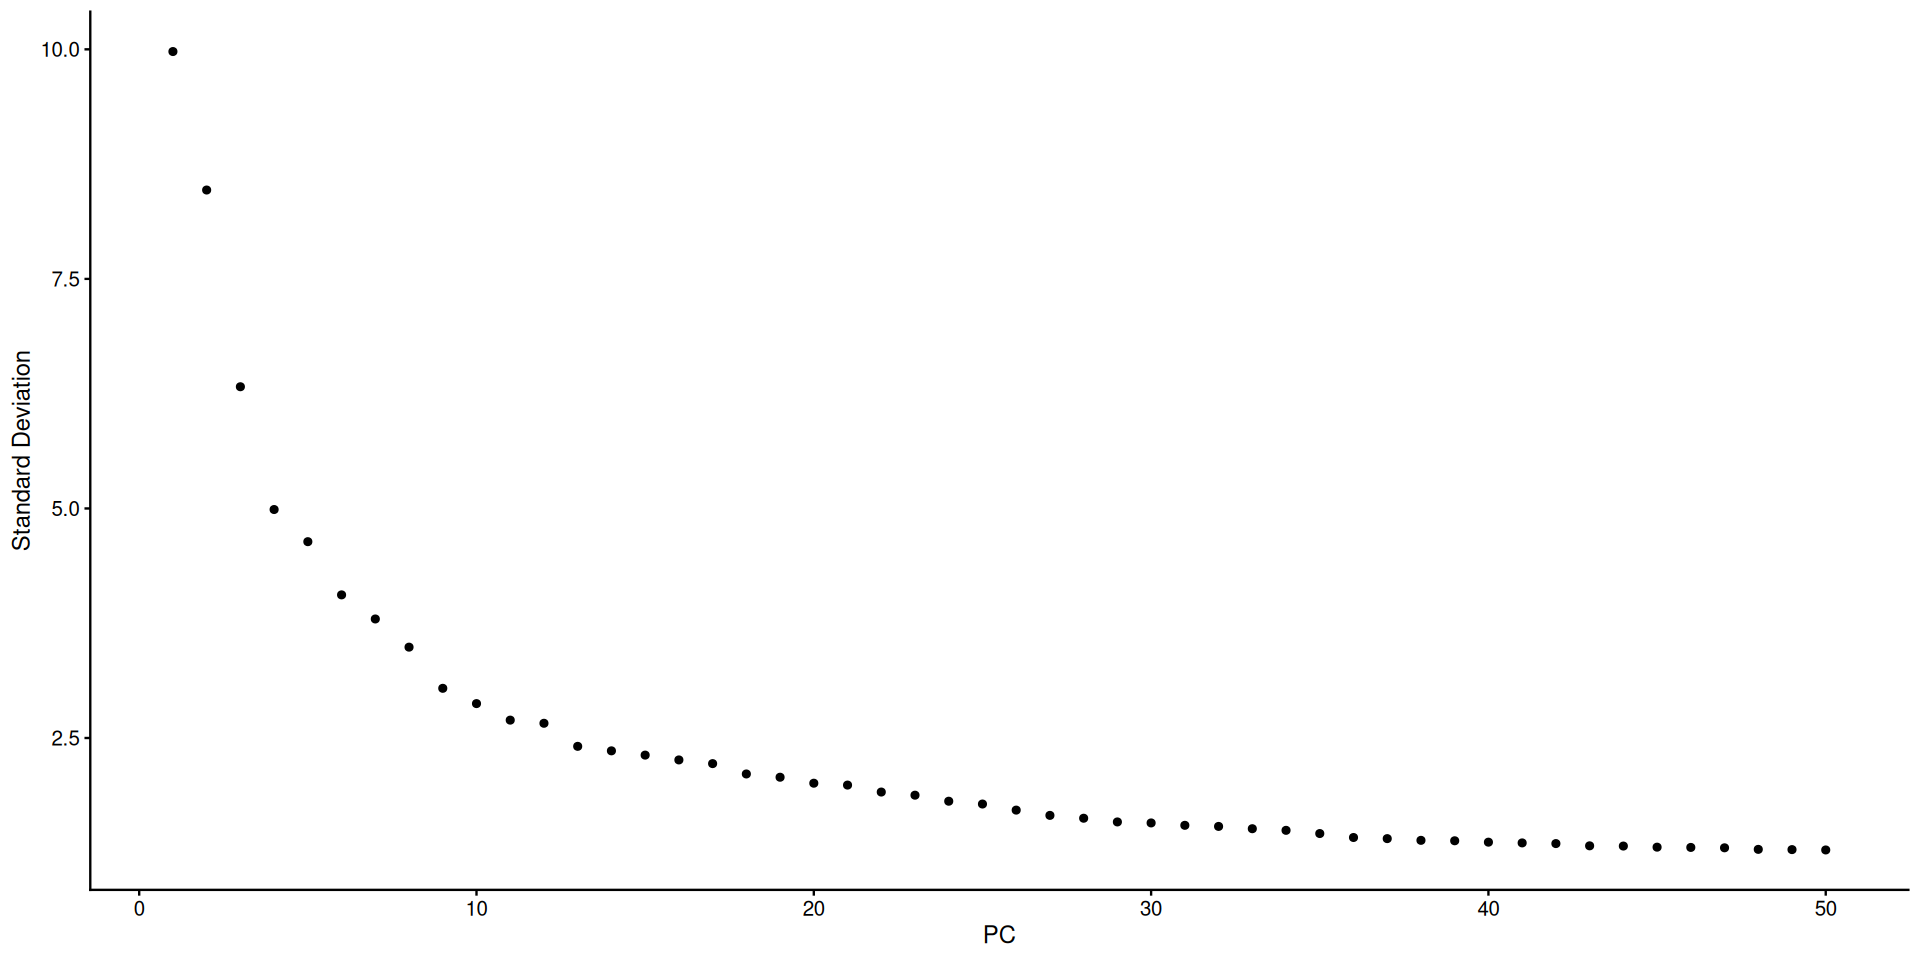

In [32]:
DimHeatmap(seurat_obj, dims = 1:5, cells = 500, balanced = TRUE)
ElbowPlot(seurat_obj, ndims = 50)  

In [33]:
# Find neighbors and clusters
seurat_obj <- FindNeighbors(seurat_obj, dims = 1:20)
seurat_obj <- FindClusters(seurat_obj, resolution = 0.3)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 33206
Number of edges: 1273665

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9643
Number of communities: 25
Elapsed time: 3 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:42:03 UMAP embedding parameters a = 0.9922 b = 1.112

15:42:03 Read 33206 rows and found 20 numeric columns

15:42:03 Using Annoy for neighbor search, n_neighbors = 30

15:42:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:42:05 Writing NN index file to temp file /tmp/RtmpThahK6/file64ff326e5b49

15:42:05 Searching Annoy index using 1 thread, search_k = 3000

15:42:13 Annoy recall = 100%

15:42:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors 

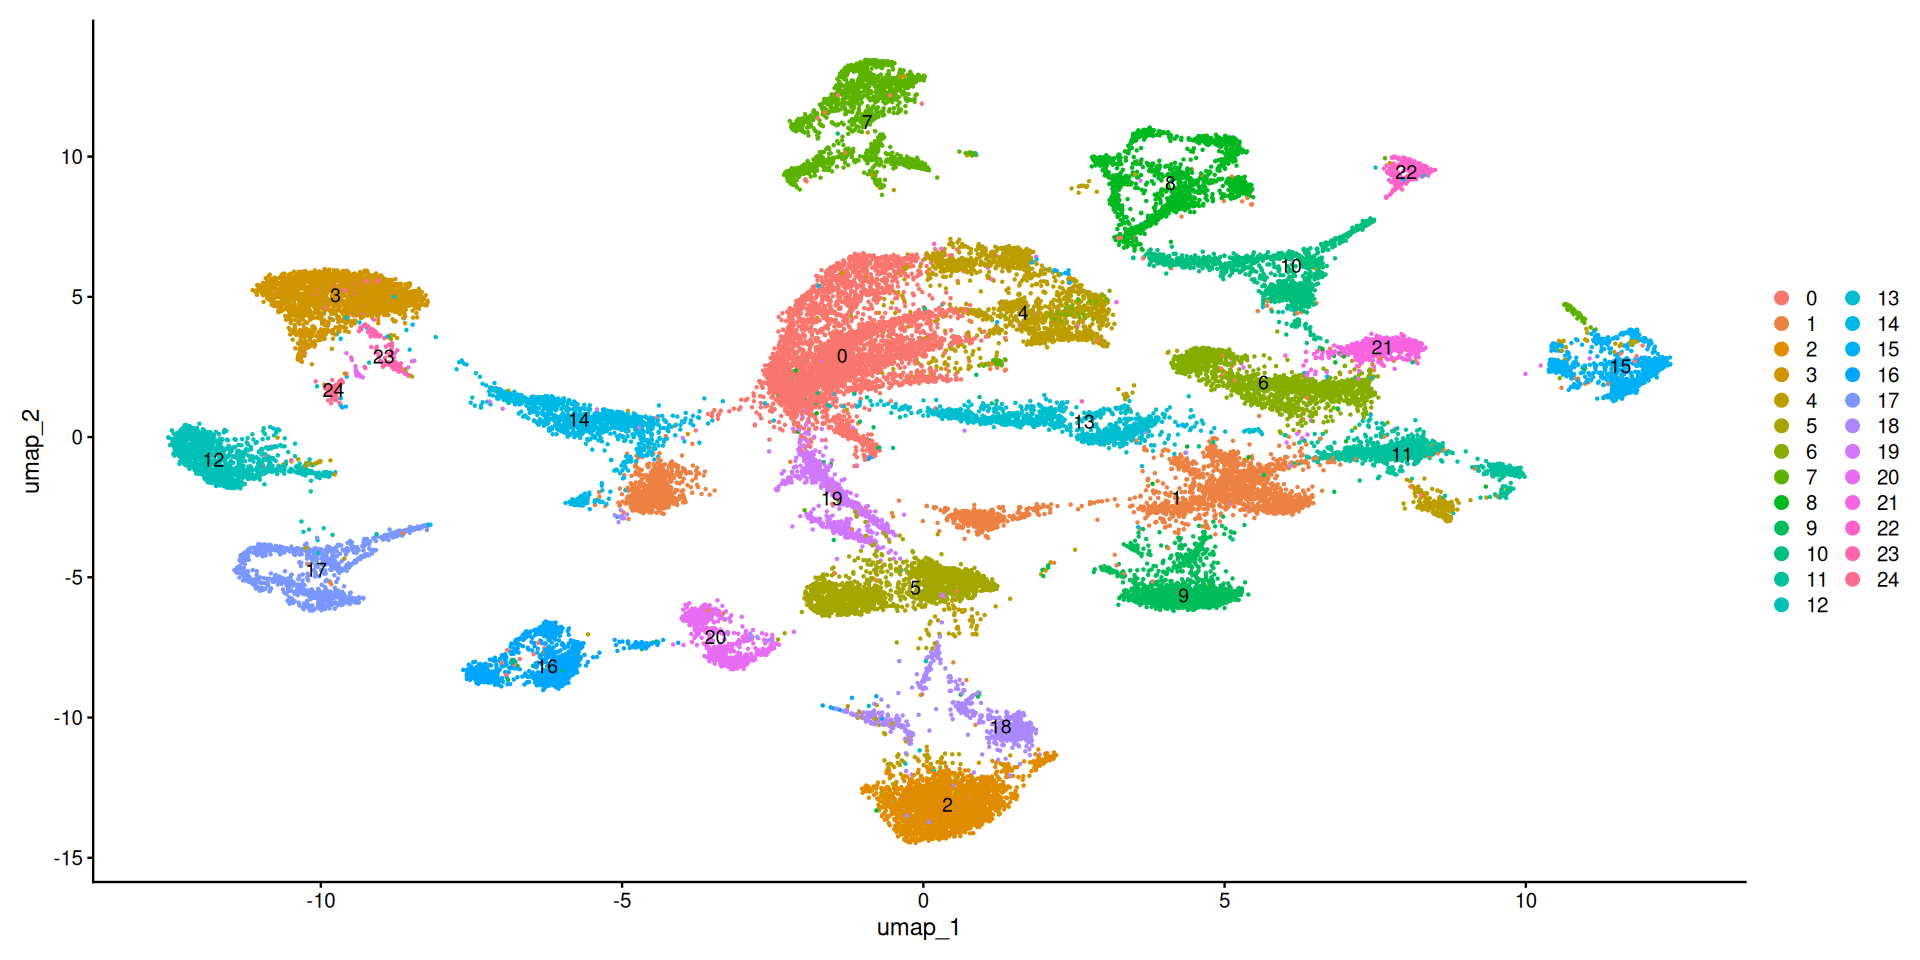

In [34]:
# Run UMAP for visualization
seurat_obj <- RunUMAP(seurat_obj, dims = 1:20)

# Visualize the clustering
DimPlot(seurat_obj, reduction = "umap", label = TRUE)

In [36]:
# save.image(file = "estephany3.RData")
# load("estephany3.RData")

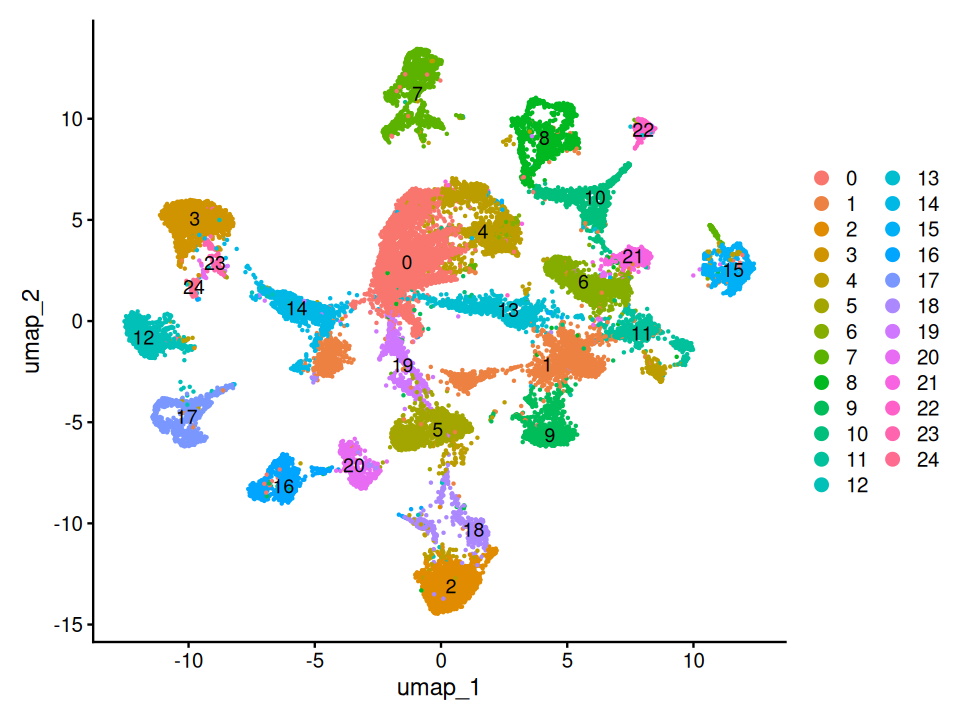

In [42]:
options(repr.plot.width = 8, repr.plot.height = 6)
DimPlot(seurat_obj, reduction = "umap", label = TRUE)

[1] "UMAP visualization of pre-annotated cell clusters"


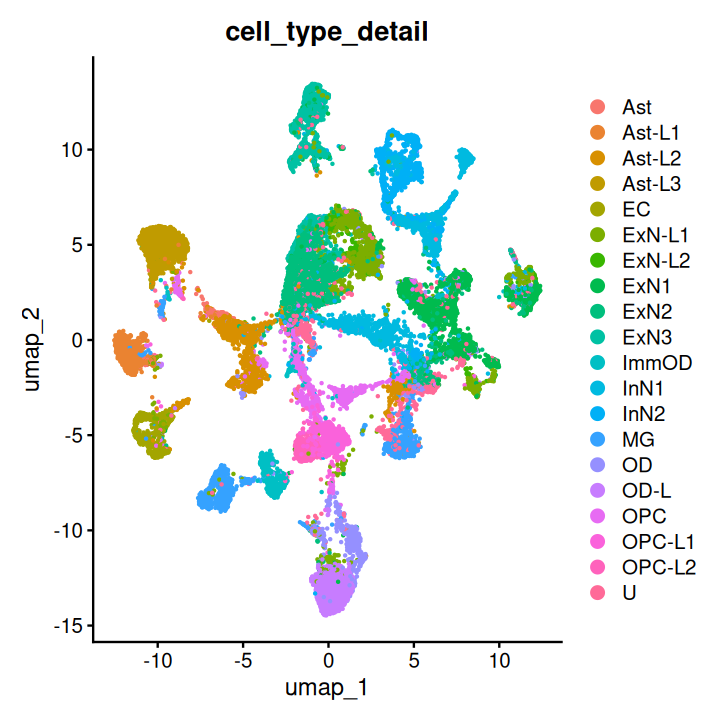

In [57]:
print("UMAP visualization of pre-annotated cell clusters")
DimPlot(seurat_obj, reduction = "umap", group.by = "cell_type_detail")

In [43]:
length(unique(seurat_obj@meta.data$cell_type_detail))

[1] 20

[1] "excitatory neurons"


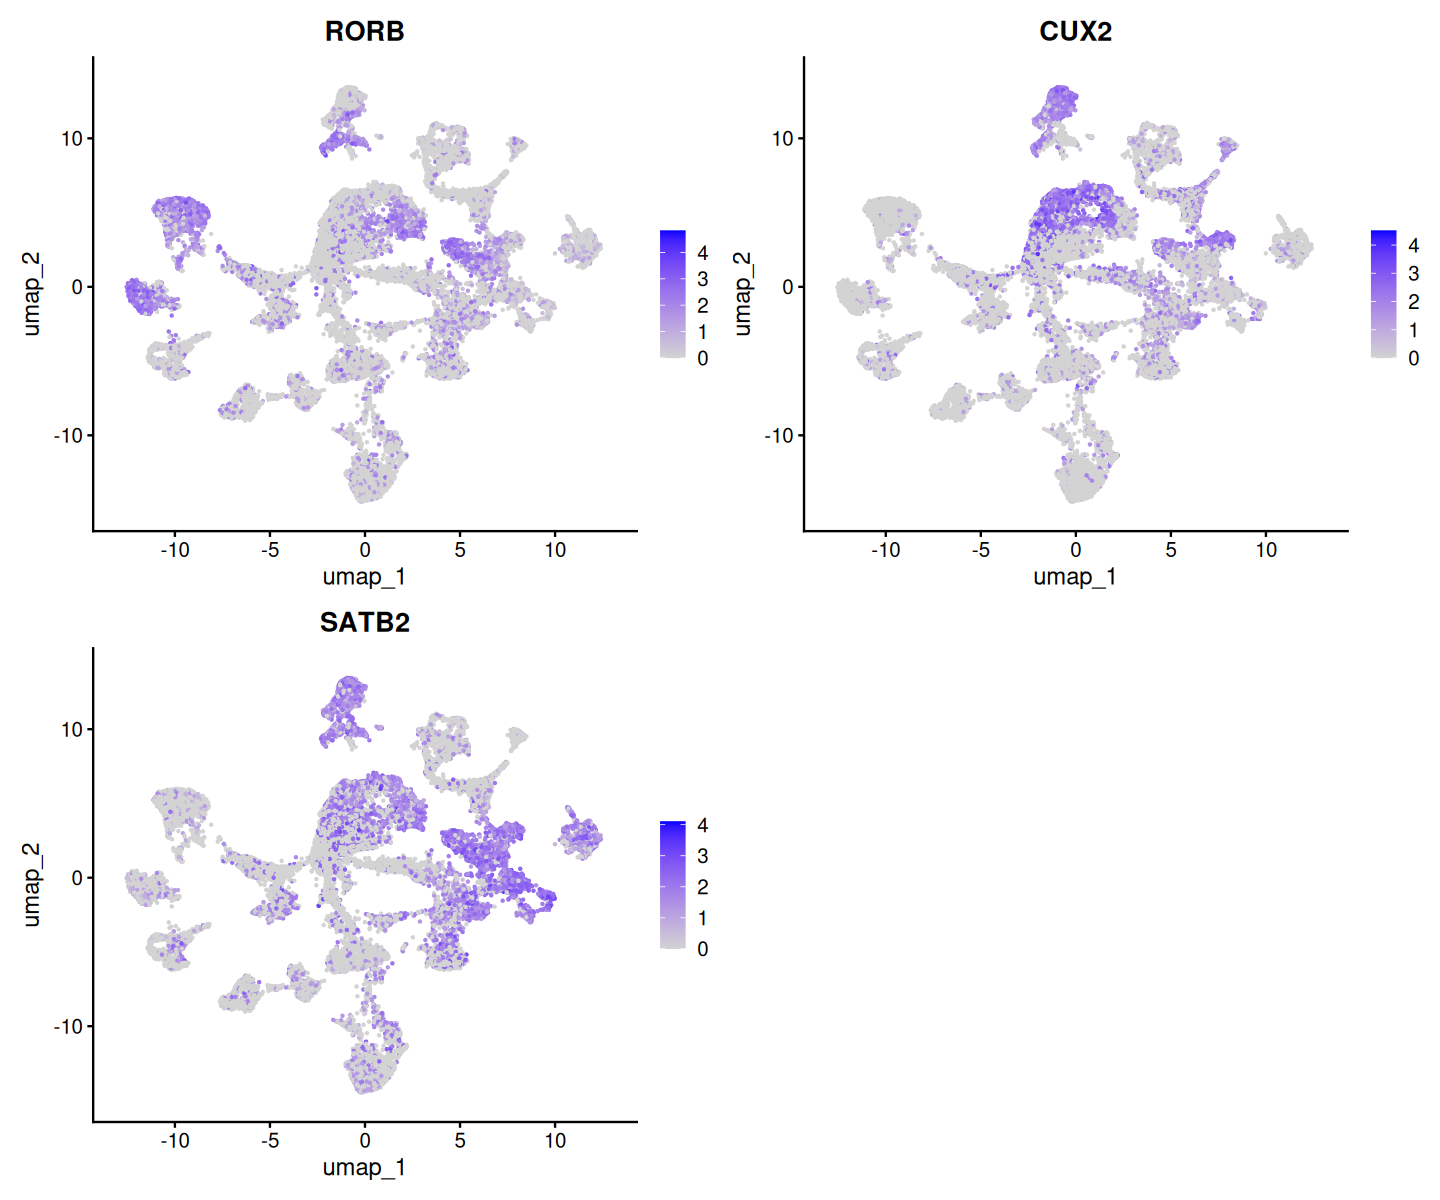

In [58]:
options(repr.plot.width = 12, repr.plot.height = 10)
print("excitatory neurons") 
FeaturePlot(seurat_obj, features = c("RORB", "CUX2", "SATB2"))  

[1] "inhibitory neurons"


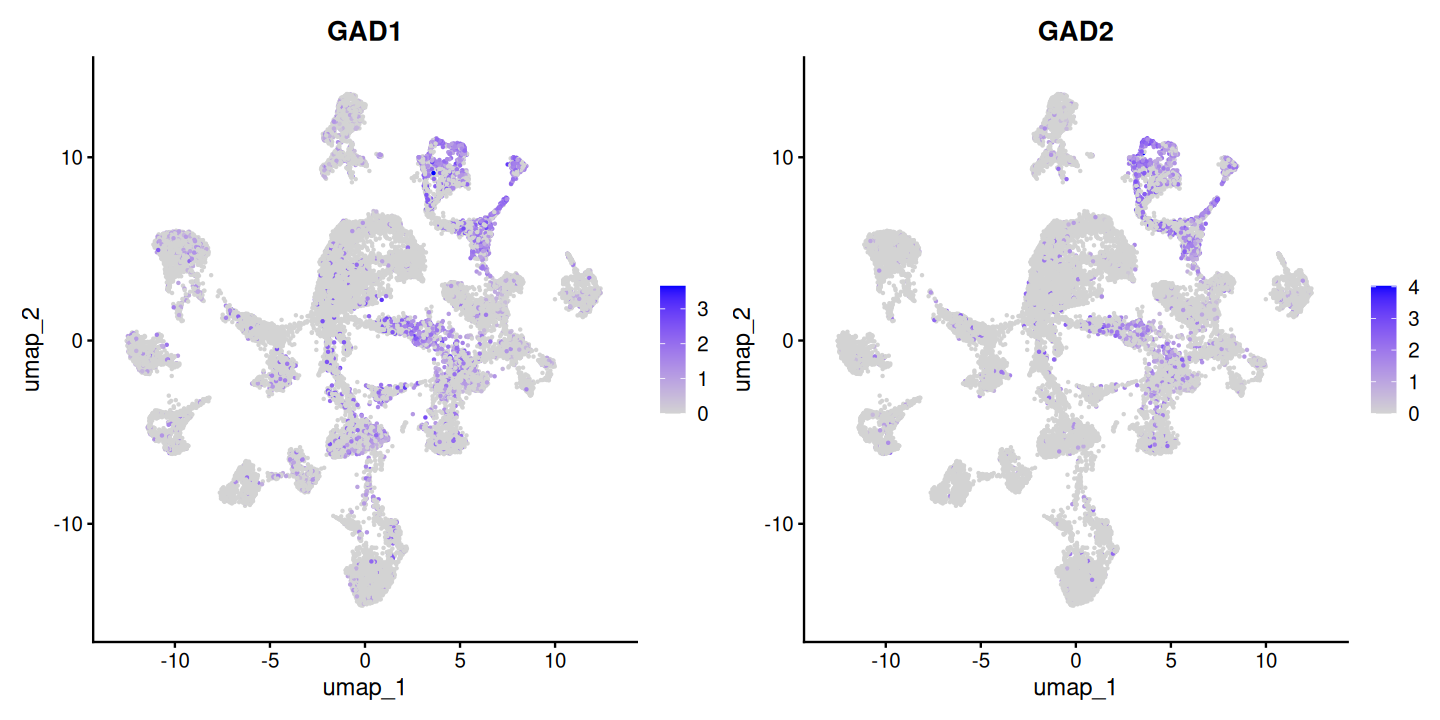

In [59]:
options(repr.plot.width = 12, repr.plot.height = 6)
print("inhibitory neurons")
FeaturePlot(seurat_obj, features = c("GAD1", "GAD2"))  

[1] "astrocytes"


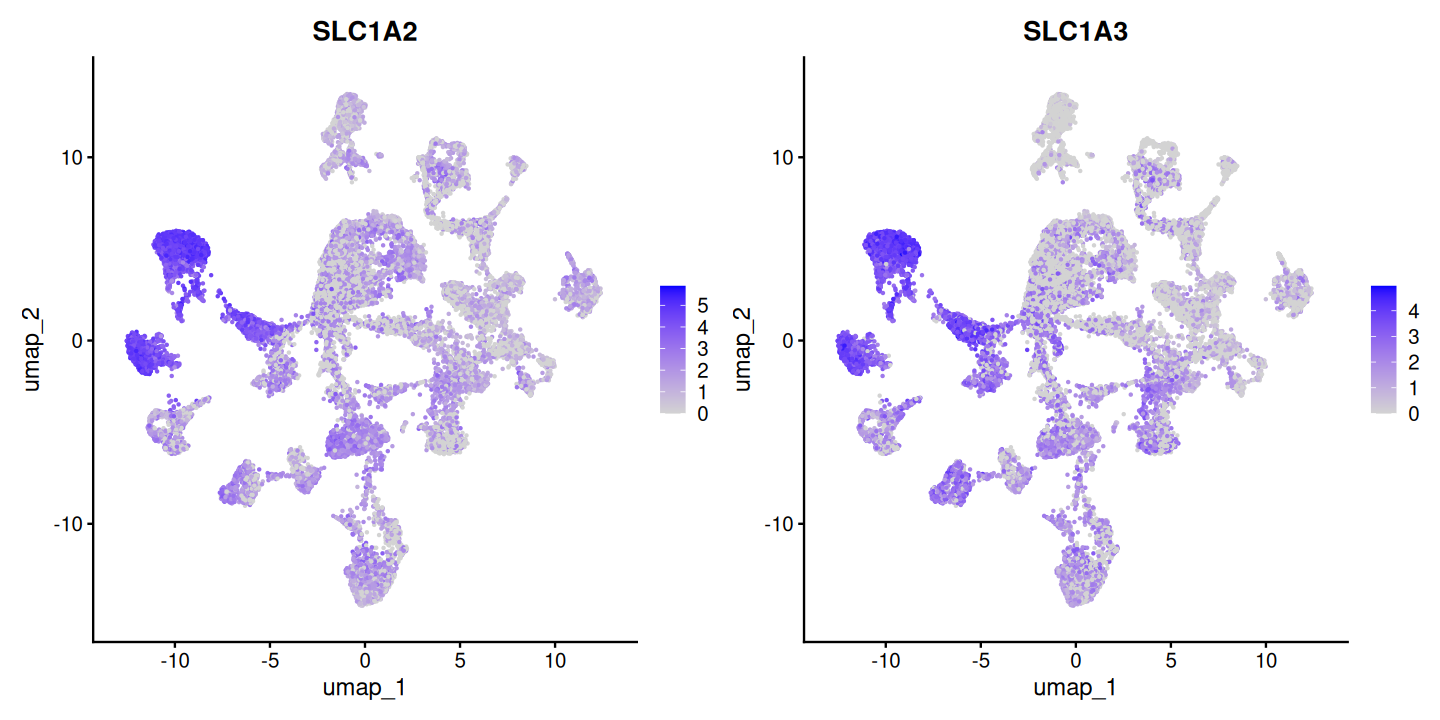

In [60]:
options(repr.plot.width = 12, repr.plot.height = 6)
print("astrocytes") 
FeaturePlot(seurat_obj, features = c("SLC1A2", "SLC1A3"))  

[1] "oligodendrocyte"


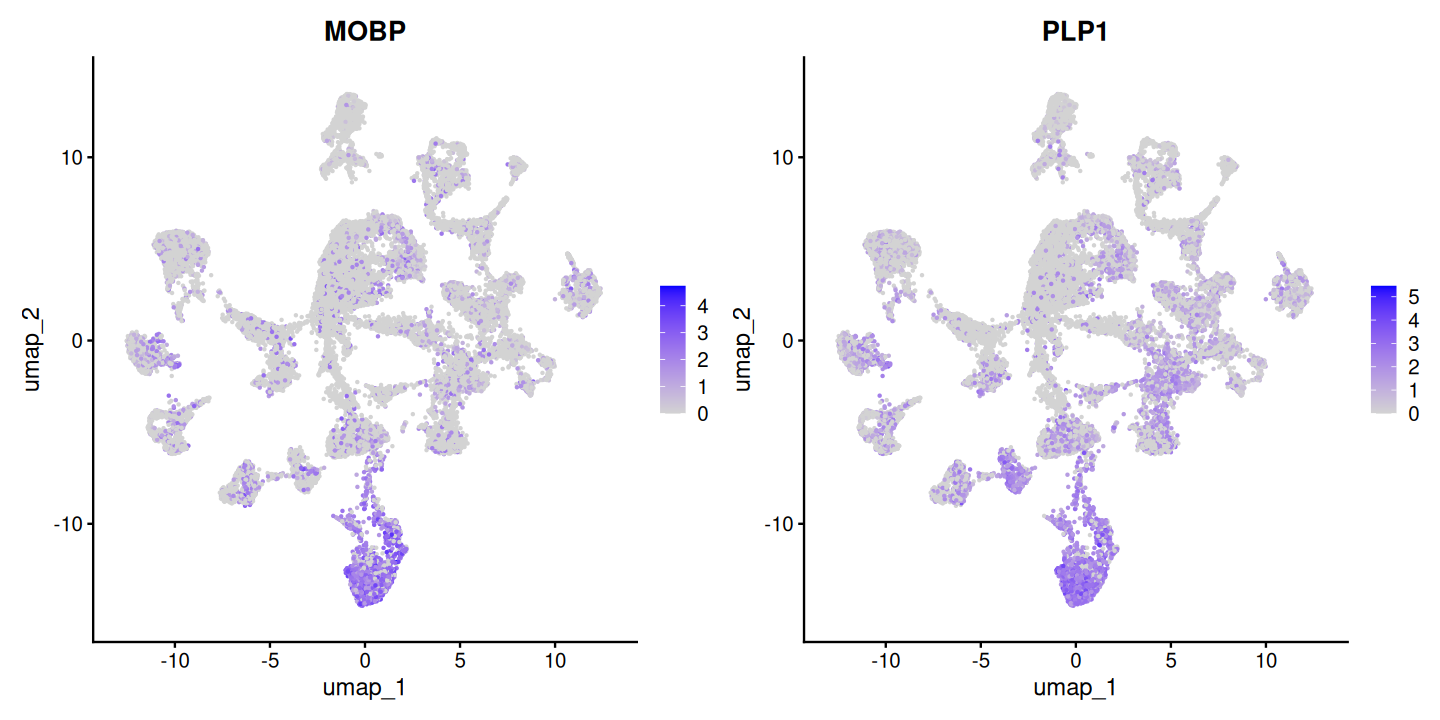

In [61]:
options(repr.plot.width = 12, repr.plot.height = 6)
print("oligodendrocyte") 
FeaturePlot(seurat_obj, features = c("MOBP", "PLP1"))  

[1] "immature oligodendrocyte"


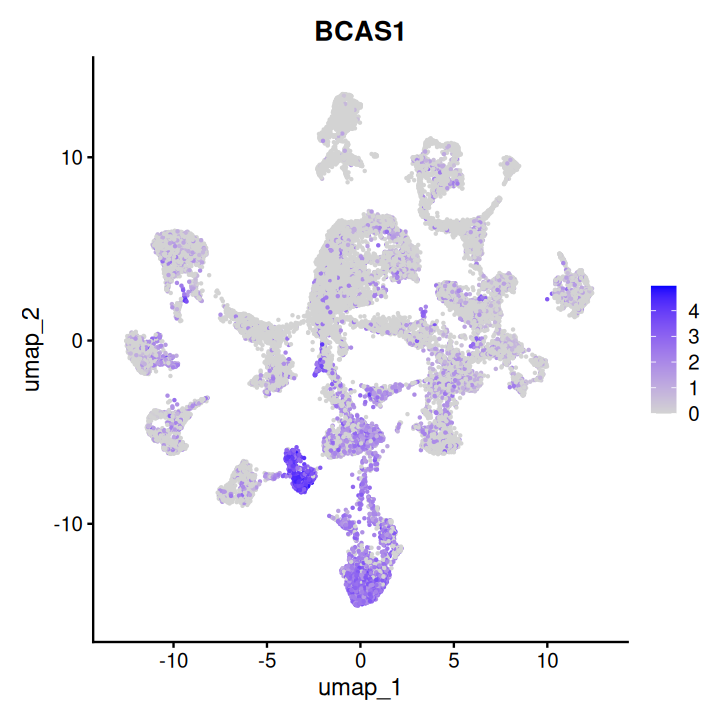

In [62]:
options(repr.plot.width = 6, repr.plot.height = 6)
print("immature oligodendrocyte") 
FeaturePlot(seurat_obj, features = c("BCAS1"))  

[1] "oligodendrocyte precursor cell"


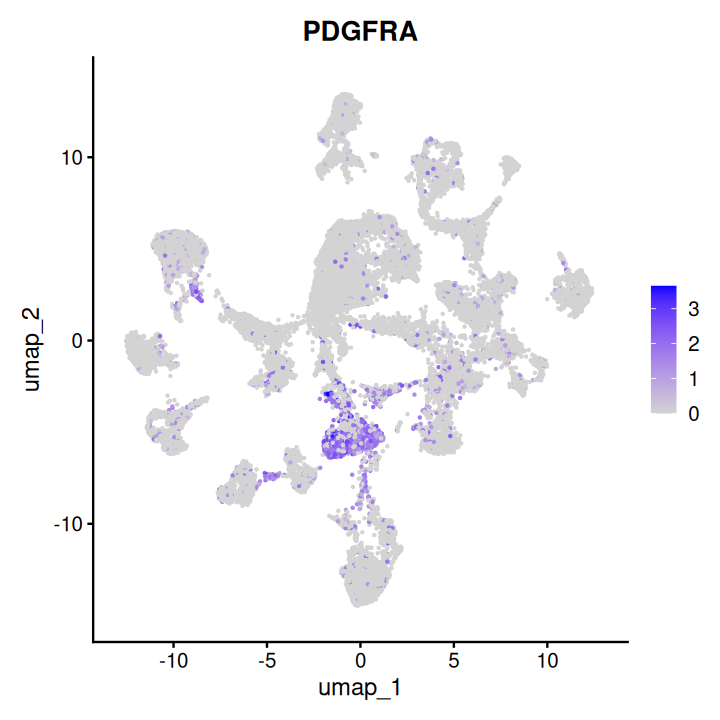

In [63]:
options(repr.plot.width = 6, repr.plot.height = 6)
print("oligodendrocyte precursor cell") 
FeaturePlot(seurat_obj, features = c("PDGFRA"))  

[1] "microglia"


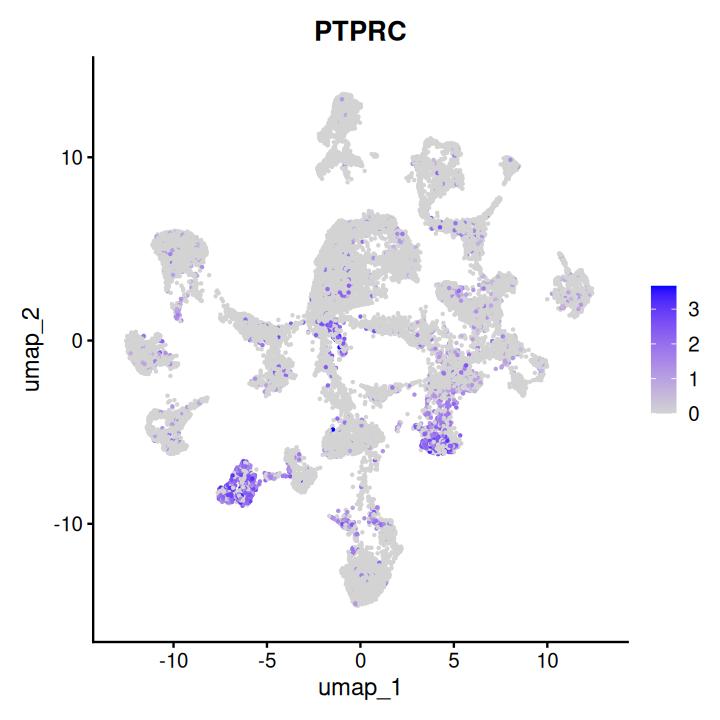

In [64]:
options(repr.plot.width = 6, repr.plot.height = 6)
print("microglia") 
FeaturePlot(seurat_obj, features = c("PTPRC"))  

[1] "endothelial cells"


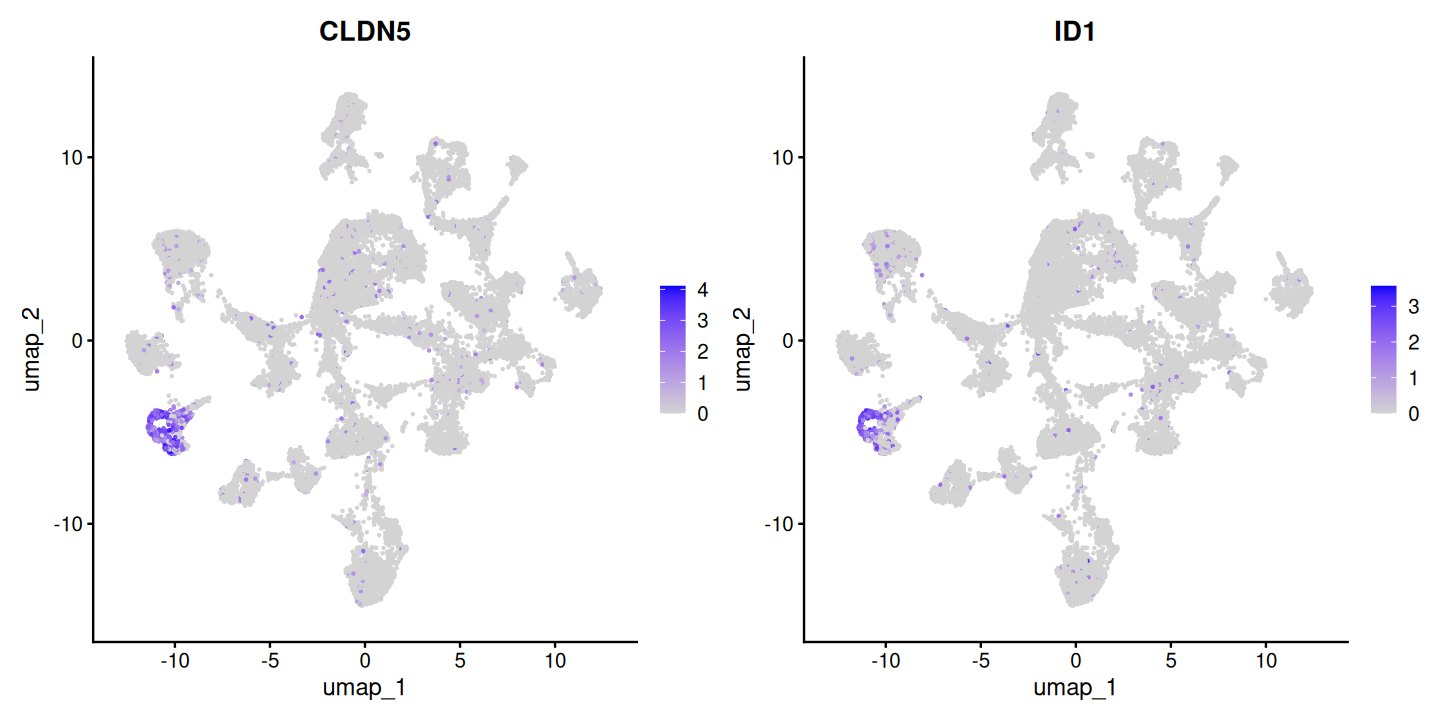

In [67]:
options(repr.plot.width = 12, repr.plot.height = 6)
print("endothelial cells") 
FeaturePlot(seurat_obj, features = c("CLDN5", "ID1"))  

Warning message:
“The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”


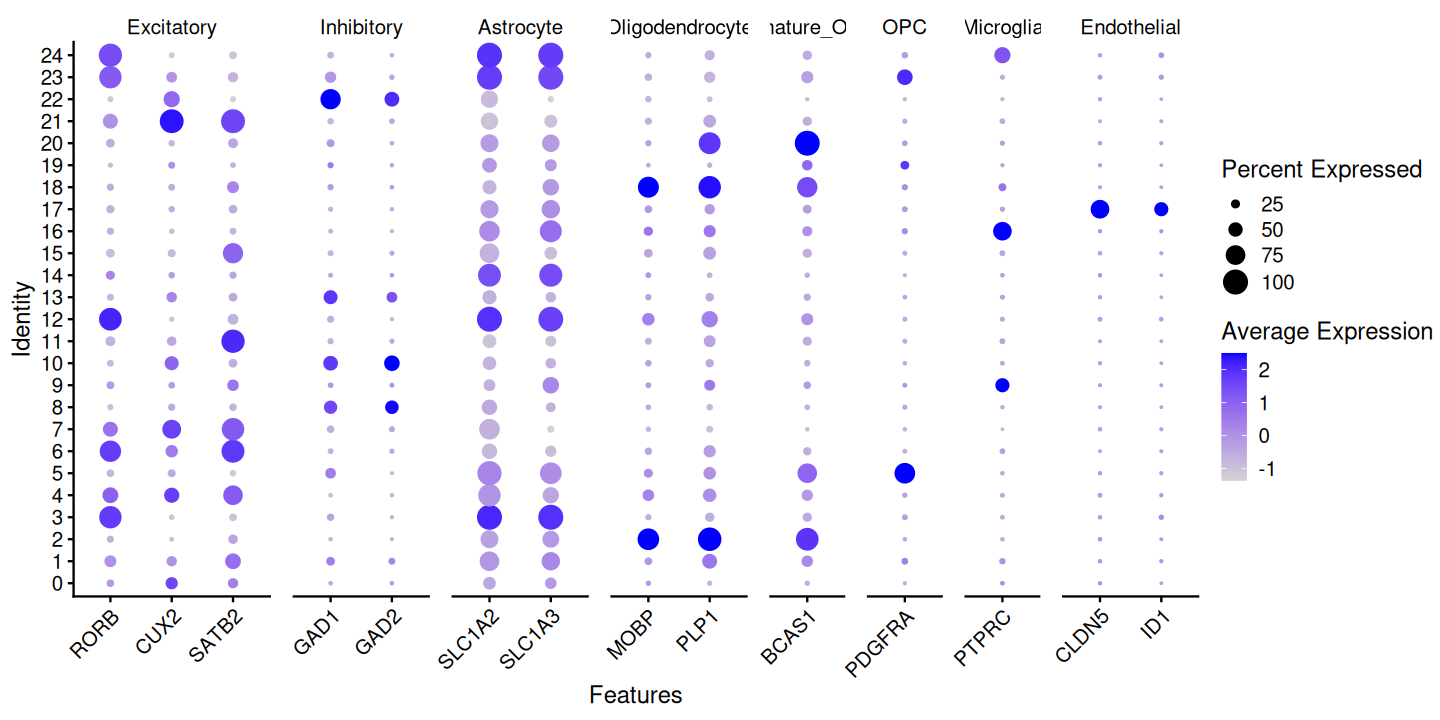

In [68]:
DotPlot(seurat_obj, features = list(
  Excitatory = c("RORB", "CUX2", "SATB2"),
  Inhibitory = c("GAD1", "GAD2"),
  Astrocyte = c("SLC1A2", "SLC1A3"),
  Oligodendrocyte = c("MOBP", "PLP1"),
  Immature_Oligo = c("BCAS1"),
  OPC = c("PDGFRA"),
  Microglia = c("PTPRC"),
  Endothelial = c("CLDN5", "ID1")
)) + RotatedAxis()

In [69]:
# Find markers for each cluster
cluster_markers <- FindAllMarkers(seurat_obj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.csv(cluster_markers, file = "cluster_markers.csv", row.names = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

